## Setup

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import interpolation
from collections import defaultdict
from scipy.stats import circmean, binned_statistic_2d
import forward_models_causal_inference
from custom_causal_inference import CustomCausalInference
import utils

In [2]:
gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'

In [ ]:
with open(gam_data_path, 'rb') as f:
    Peter_gam_data = pickle.load(f)
r_n_key = 'r_n'
len(Peter_gam_data[r_n_key]), len(Peter_gam_data['s_n']), Peter_gam_data.keys()

In [4]:
with open('./uniform_model_base_inv_kappa_free.pkl', 'rb') as f:
    Peter_u_map = pickle.load(f)
Peter_u_map.keys()

dict_keys(['samples', 'responses', 'sim_responses', 'seed', 'lr', 'log_u_sigma', 'pdf_centers', 'pdf_log_weights', 'pdf_log_widths', 'sim_hist', 'pdf', 'grid', 'losses'])

## Data vis and filtering

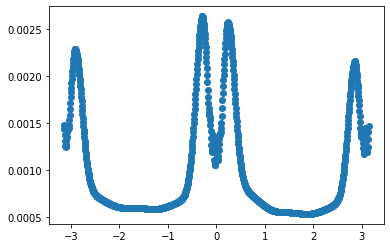

In [5]:
plt.plot(Peter_u_map['grid'], Peter_u_map['pdf'], 'o', label='Peter uniform model')

### Filter lapses

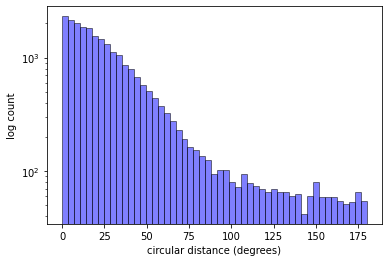

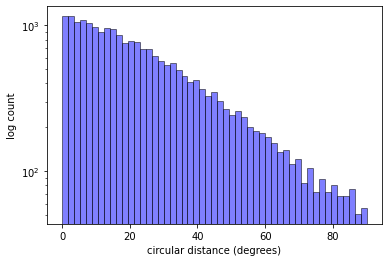

In [6]:
# plot circular distance between s_n and r_n
plt.hist(np.rad2deg(utils.circular_dist(Peter_gam_data['s_n'], Peter_gam_data['r_n'])), bins=51, 
         density=False, alpha=0.5, label='circular distance between s_n and r_n', 
         log=True, color='blue', edgecolor='black')
plt.xlabel('circular distance (degrees)')
plt.ylabel('log count')
plt.show()
filtered_gam_data = utils.get_filtered_gam(Peter_gam_data, max_circ_dist=np.pi/2)
plt.hist(np.rad2deg(utils.circular_dist(filtered_gam_data['s_n'], filtered_gam_data['r_n'])), bins=51, 
         density=False, alpha=0.5, label='circular distance between s_n and r_n', 
         log=True, color='blue', edgecolor='black')
plt.xlabel('circular distance (degrees)')
plt.ylabel('log count')
plt.show()

In [7]:
gam_data = filtered_gam_data
r_n_key = 'r_n'

### Serial dependence plots

In [8]:
# Create dataset with s_n, s_n_1, r_n, r_n_1
serial_dep_data = np.zeros((len(gam_data['s_n'])-1, 5))
for index in range(len(gam_data['s_n'])-1):
    serial_dep_data[index, :] = np.array([gam_data['s_n'][index+1], gam_data['s_n'][index], gam_data[r_n_key][index+1], gam_data[r_n_key][index], index+1])

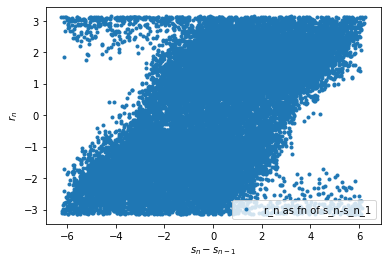

In [9]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

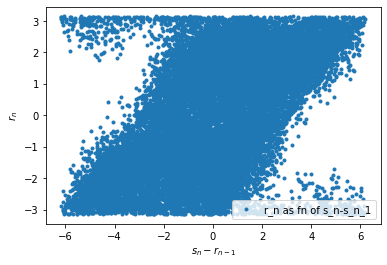

In [10]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 3], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-r_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

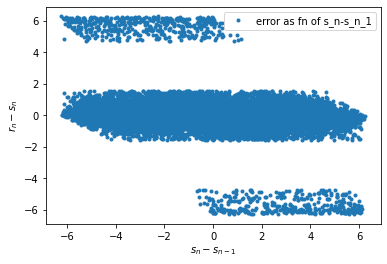

In [11]:
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2] - serial_dep_data[order_sn, 0], '.', label='error as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n-s_n$')
plt.legend()
plt.show()

### Mean response over grid from filtered data

Fraction of H where value is nan: 0.0


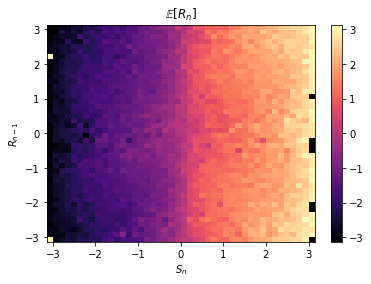

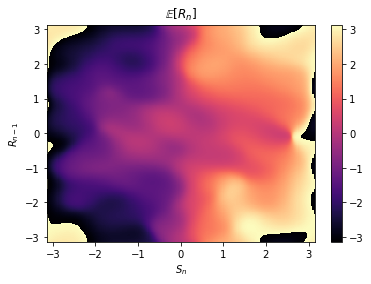

In [18]:
# TODO: For matching Peter's binsize, the histogram has 70% nan values; Fill missing values using linear interp,
# Gaussian smooting or circular-distance transforms (i.e. nearest non-nan cell). For now, use coarse binning.
binning = 44
circmean_mpi_pi = lambda x: circmean(x, high=np.pi, low=-np.pi)
H, xedges, yedges, binnumber = binned_statistic_2d(y=gam_data['r_n'][:-1], x=gam_data['s_n'][1:], 
                                                   values=gam_data['r_n'][1:], 
                                            statistic=circmean_mpi_pi, bins=binning, expand_binnumbers=True)
XX, YY = np.meshgrid(xedges, yedges)
print(f'Fraction of H where value is nan: {np.sum(np.isnan(H)) / H.size}')

plt.pcolormesh(XX,YY,H.T,cmap='magma')#,vmin=-0.4,vmax=0.4)
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[R_{n}]$')
plt.show()

_, xedges_250, yedges_250, _ = binned_statistic_2d(y=gam_data['r_n'][:-1], x=gam_data['s_n'][1:], 
                                                   values=gam_data['r_n'][1:], 
                                            statistic=circmean_mpi_pi, bins=250, expand_binnumbers=True)
plt.pcolormesh(*np.meshgrid(xedges_250, yedges_250),Peter_gam_data['full_pdf_mat'][:, :, 0],cmap='magma')
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[R_{n}]$')
plt.show()

## Using the mean response as internal space map

In [22]:
def sn_to_mean_rn_map(s_ns, r_ns, sn_grid=None):
    if sn_grid is None:
        sn_grid = np.linspace(-np.pi, np.pi, 1000)
    responses = defaultdict(list)
    for sn, rn in zip(s_ns, r_ns):
        index_in_grid = int(interpolation.find_closest_mu_bs(mu=sn, mus=sn_grid))
        responses[index_in_grid].append(rn)
    mean_responses = np.array([circmean(high=np.pi, low=-np.pi, samples=responses[i]) for i in range(len(sn_grid))])
    return sn_grid, mean_responses

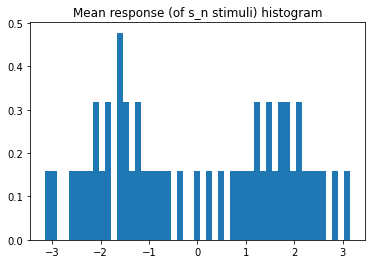

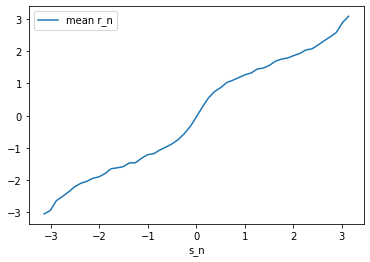

In [27]:
# sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=Peter_u_map['grid'])
sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=np.linspace(-np.pi, np.pi, 51))   
bin_counts, _, _ = plt.hist(mean_r_n, bins=np.linspace(-np.pi, np.pi, len(sn_grid)+1), density=True)
plt.title('Mean response (of s_n stimuli) histogram')
plt.show()
# handle wrap
plt.plot(sn_grid, mean_r_n, label='mean r_n')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'pdf': bin_counts, 'angle_to_u': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

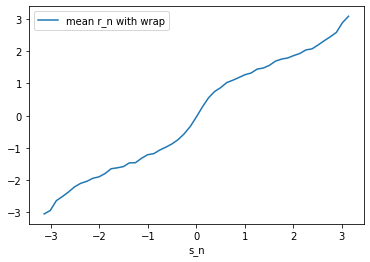

In [28]:
mean_r_n_wrap = np.array(mean_r_n)
for idx, (sn, mrn) in enumerate(zip(sn_grid, mean_r_n)):
    if abs(sn - mrn) > np.pi:
        print(idx, sn, mrn)
        mean_r_n_wrap[idx] = np.min(mean_r_n_wrap[idx:idx+7])
    if (idx > 0) and (mean_r_n_wrap[idx] < mean_r_n_wrap[idx-1]):
        print(f'not monotonic: {idx, mean_r_n_wrap[idx], mean_r_n_wrap[idx-1], sn}')
plt.plot(sn_grid, mean_r_n_wrap, label='mean r_n with wrap')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'f': mean_r_n_wrap, 'f_inv': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

In [29]:
stimuli_grid = np.linspace(-np.pi, np.pi, 250)
t_index = 0  # use r_n_1 as regressor
causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
        model=CustomCausalInference(decision_rule='mean'),
        angle_gam_data_path=gam_data_path,
        unif_fn_data_path='./mean_response_map.pkl',)
mean_response_map = causal_inference_estimator.unif_map

In [30]:
def get_repulsion_mat(sns, ts, rns):
    repulsion = np.zeros_like(sns)
    for idx, (t, s_n, r_n) in enumerate(zip(ts, sns, rns)):
        us_n = mean_response_map.angle_space_to_unif_space(s_n)
        ut = mean_response_map.angle_space_to_unif_space(t)
        ur_n = mean_response_map.angle_space_to_unif_space(r_n)
        if utils.circular_dist(us_n, ut) < utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n):
            repulsion[idx] = utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n) - utils.circular_dist(us_n, ut)
    return repulsion

In [31]:
def plot_heatmap_uspace(data, usns, uts, grid_dim, title):
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
            data, shading='auto', cmap='magma')
    plt.colorbar(label='circular distance to r_n(t, s_n)')
    plt.xlabel('us_n')
    plt.ylabel('ut')
    plt.title(title)
    plt.show()

Comparing with fits

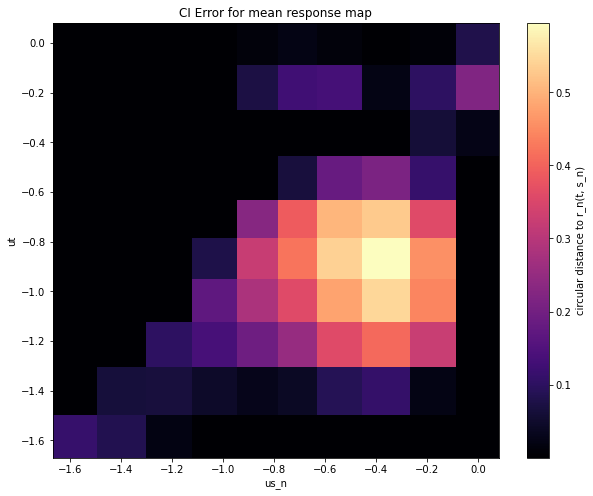

In [32]:
grid_sz = 100
optimal_kappa_pairs_filepath = f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_pc_filepath = f'./learned_data/min_error_for_idx_pc_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_filepath = f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}.pkl'
s_ns_filepath = f'./learned_data/selected_s_n_{grid_sz}_t{t_index}.npy'
ts_filepath = f'./learned_data/selected_t_{grid_sz}_t{t_index}.npy'
r_ns_filepath = f'./learned_data/selected_r_n_{grid_sz}_t{t_index}.npy'
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)
grid_dim = int(np.sqrt(s_ns.shape[0]))
err_mat = np.zeros_like(s_ns).reshape((grid_dim, grid_dim))
for i in range(grid_dim):
    for j in range(grid_dim):
        err_mat[i, j] = min_error_for_idx['sn'][i*grid_dim+j]
plot_heatmap_uspace(err_mat, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='CI Error for mean response map')

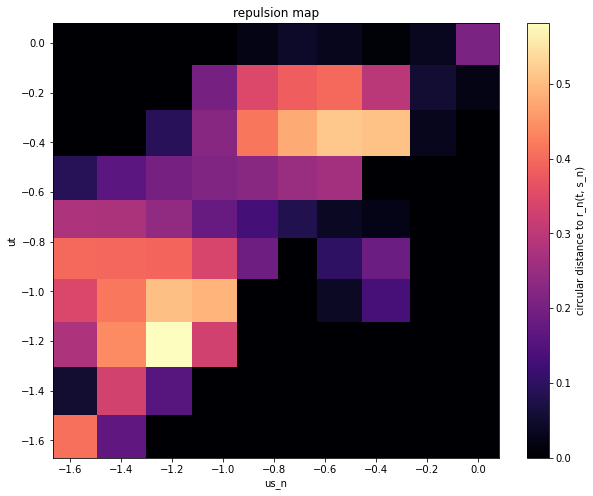

In [33]:
repulsion = get_repulsion_mat(s_ns, ts, r_ns).reshape((grid_dim, grid_dim))
plot_heatmap_uspace(repulsion, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='repulsion map')